# Experiments
### Notebook to run experiments on the data supplied by the chair of functional materials at Saarland University

## Experiment 1
### Run RAFT optical flow model on the data
In this experiment we will run the RAFT optical flow model on the data to see how well it performs compared to classical optical flow methods.


### Results
RAFT tracks the reaction front quite well. The reaction front is visible in the optical flow images but there is also a lot of noise.

In [ ]:
import torch
from src.raft import get_video_frames, plot_frames, preprocess

In [ ]:
video_path = "videos/double_c_shape.mp4"
frames = get_video_frames(video_path)

In [ ]:
# Change the numbers in frames to see different images.
img_batch = torch.stack([frames[50], frames[51]])
plot_frames(img_batch)

In [ ]:
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow.raft import Raft_Large_Weights

model = raft_large(weights=Raft_Large_Weights.C_T_V2)
model = model.eval()

In [ ]:
img1_batch: torch.Tensor = preprocess(torch.stack([frames[130], frames[220]]))
img2_batch: torch.Tensor = preprocess(torch.stack([frames[131], frames[221]]))

plot_frames(img1_batch)

In [ ]:
img1_batch.shape

In [ ]:
predicted_flows: torch.Tensor = model(img1_batch, img2_batch)[-1]

In [ ]:
from torchvision.utils import flow_to_image

flow_images = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = (img1_batch + 1.0) / 2.0

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_images)]
plot_frames(grid)

## Experiment 2
### Obtain reaction front from difference between frames
In this experiment we will see how well we can obtain the reaction front by simply taking the difference between frames. We set pixels with very small and large differences between two frames to zero, as they seem to be noise. We also binarize the image to make the front more visible. For further denoising we apply a morphological operation called <i>Opening</i>, which removes all white spots smaller than a certain size. Mathematical morphology in the context of image processing deals with analysing and modifying structures in an image based on their geometrical properties. 


### Results
The reaction front is actually quite visible in the difference between frames. This is a very simple method to obtain the reaction front.  The method also seems to outperform the old optical flow method in terms of noise and also speed.


In [ ]:
from skimage import morphology
from tqdm import tqdm
from src.utils.video_handling import get_video_frames
import numpy as np
import cv2
import os

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
footprint = morphology.disk(3)

for video_name in os.listdir("videos/"):
    print(f"Generating flow for {video_name}")
    video_path = "videos/" + video_name
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    frames = get_video_frames(video_path)
    dir_name = "results/experiment2/"
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
    video_writer = cv2.VideoWriter(dir_name + video_name, fourcc, 10.0, (width, height))
    for i, _ in tqdm(enumerate(frames[:-1])):
        # Calculate the difference between two frames.
        flow = frames[i + 1] - frames[i]
        flow = flow.astype(np.uint8)

        # Threshold and binarize the image.
        flow[flow > 180] = 0
        flow[flow < 20] = 0
        flow[flow > 0] = 255

        # Apply morphological opening.
        flow = morphology.opening(flow, footprint)
        flow = cv2.cvtColor(flow, cv2.COLOR_GRAY2BGR)
        video_writer.write(flow)

    video_writer.release()

## Experiment 3
### Track the reaction fronts through the frames
In this experiment we will try to track the reaction front and its offsprings throughout the frames. Since the images will be binarized we can use local connectivity of the pixels as a criterion for tracking. 

### Results
Segmenting the reaction front and it's offspring works quite good on a per frame basis, but it's difficult to track the different fronts throughout the frames.

In [ ]:
from skimage import morphology, measure
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.utils.video_handling import get_video_frames
import numpy as np
import cv2
import os

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
footprint = morphology.disk(3)

cmap = plt.get_cmap("tab20")
props_old = None

for video_name in os.listdir("videos/"):
    print(f"Generating flow for {video_name}")
    video_path = "videos/" + video_name
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    frames = get_video_frames(video_path)
    video_writer = cv2.VideoWriter(
        "results/experiment3/" + video_name, fourcc, 10.0, (width, height)
    )
    for i, _ in tqdm(enumerate(frames[:-1])):
        # Calculate the difference between two frames.
        flow = frames[i + 1] - frames[i]
        flow = flow.astype(np.uint8)

        # Threshold and binarize the image.
        flow[flow > 180] = 0
        flow[flow < 20] = 0
        flow[flow > 0] = 255

        # Apply morphological opening.
        flow = morphology.opening(flow, footprint)

        # Label the connected components.
        labeled_flow, num_labels = measure.label(flow, return_num=True)
        labeled_flow = cv2.cvtColor(labeled_flow.astype(np.uint8), cv2.COLOR_GRAY2BGR)
        flow = cv2.cvtColor(flow, cv2.COLOR_GRAY2BGR)

        for j in range(1, num_labels):
            color = cmap(j)
            color_array = (np.array(color[:-1]) * 255).astype(np.uint8)
            flow = np.where(labeled_flow == j, color_array, flow)

        video_writer.write(flow)

    video_writer.release()

## Experiment 4
### Apply optical flow to the binarized video frames
In this experiment we will apply an optical flow algorithm to the binarized videos to get a vector field describing the speed of the reaction front at each point in time.

04.05.2024:
- Try adding skeletonization before calculating the optical flow and use opencv's calcOpticalFlowFarneback function.

05.05.2024:
- I tried playing around with the parameters of the algorithm like *poly_sigma* and *poly_n*.
<br><br>

### Hypothesis
Since the frames are almost noise free I expect the optical flow algorithm to perform quite well on the data.
<br><br>

### Results
The algorithm fails spectacularly, seemingly tracking the reaction fronts but also causing seemingly random splashes of gray tones.

04.05.2024:
- After applying skeletonization there are no splashes anymore, but there still is noise and the flow seems to be too thick.

05.05.2024:
- Modifying the parameters doesn't improve the result.

In [ ]:
from skimage import morphology
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.utils.video_handling import get_video_frames
import numpy as np
import cv2
import os

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
footprint = morphology.disk(3)

cmap = plt.get_cmap("plasma")
props_old = None

for video_name in os.listdir("videos/"):
    print(f"Generating flow for {video_name}")
    video_path = "videos/" + video_name
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    frames = get_video_frames(video_path)

    dir_name = "results/experiment4_farneback_poly_sigma_0_2_poly_n_3/"
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)

    video_writer = cv2.VideoWriter(dir_name + video_name, fourcc, 10.0, (width, height))

    for i, _ in tqdm(enumerate(frames[1:-1])):
        # Calculate the difference between two frames.
        diff_flow0 = (frames[i + 1] - frames[i]).astype(np.uint8)
        diff_flow1 = (frames[i] - frames[i - 1]).astype(np.uint8)

        # Threshold and binarize the image.
        diff_flow0[diff_flow0 > 180] = 0
        diff_flow0[diff_flow0 < 20] = 0
        diff_flow0[diff_flow0 > 0] = 255

        diff_flow1[diff_flow1 > 180] = 0
        diff_flow1[diff_flow1 < 20] = 0
        diff_flow1[diff_flow1 > 0] = 255

        # Apply morphological opening.
        diff_flow0 = morphology.opening(diff_flow0, footprint)
        diff_flow1 = morphology.opening(diff_flow1, footprint)

        diff_flow0 = morphology.skeletonize(diff_flow0)
        diff_flow1 = morphology.skeletonize(diff_flow1)

        diff_flow0 = np.where(diff_flow0 == 1, 255, 0).astype(np.uint8)
        diff_flow1 = np.where(diff_flow1 == 1, 255, 0).astype(np.uint8)

        flow_field = cv2.calcOpticalFlowFarneback(
            diff_flow0, diff_flow1, None, 0.5, 3, 15, 3, 3, 0.2, 0
        )

        flow = np.sqrt(flow_field[:, :, 0] ** 2 + flow_field[:, :, 1] ** 2).astype(np.uint8)
        flow = cv2.cvtColor(flow, cv2.COLOR_GRAY2BGR)

        video_writer.write(flow)

    video_writer.release()


## Experiment 5
### Apply skeletonization to the binarized video frames
In this experiment we will apply skeletonization to the binarized videos to get a more sharp representation of the reaction front.

### Hypothesis
Will look like the previous experiments but with thin lines instead of blobs.

### Results
Hypothesis turned out to be correct, there is still some noise present which I might be able to remove with more morphological operations.

In [1]:
from skimage import morphology
from tqdm import tqdm
from src.utils.video_handling import setup_experiment
from src.utils.frame_processing import front_from_frames
import cv2
import os

ImportError: Bindings generation error. Submodule name should always start with a parent module name. Parent name: cv2.cv2. Submodule name: cv2

In [ ]:
footprint = morphology.disk(3)
for video_name in os.listdir("videos/"):
    video_writer, frames = setup_experiment(video_name, "results/experiment5_low_threshold_15/")
    for i, _ in tqdm(enumerate(frames[:-1])):
        front = front_from_frames(frames[i], frames[i + 1], footprint)
        front = cv2.cvtColor(front, cv2.COLOR_GRAY2BGR)
        video_writer.write(front)

    video_writer.release()

## Experiment 6
### Plot evolution of reaction front on a single canvas
In this experiment we will plot the reaction front at each time step on a single canvas to get an overview over its evolution in time from a single image.

### Results 
Fronts are clearly visible in most images. Only the videos with low resolutions and the one with the dots yield unclear images

20.05.2024
- It seems like v2 of the <i>front_from_frames</i> works better on images with small structures, while v1 works better on images with large structures.


In [ ]:
from src.utils.video_handling import get_video_frames
from src.utils.frame_processing import front_from_frames
import matplotlib.pyplot as plt
from skimage import morphology
from tqdm import tqdm
import numpy as np
import os

In [ ]:
footprint = morphology.disk(3)
for video_name in os.listdir("videos/"):
    frames = get_video_frames("videos/" + video_name)
    # Initialize the front
    h, w = frames[0].shape
    front = np.zeros((h, w), dtype=np.uint8)
    for i, _ in tqdm(enumerate(frames[:-1])):
        front += front_from_frames(frames[i], frames[i + 1], threshold=35)
    fig = plt.figure(dpi=200)
    plt.imshow(front)
    plt.axis("off")
    plt.title("Reaction Front Progression - {}".format(video_name))
    result_dir = "results/experiment6_v2_tl_35/"
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)
    plt.savefig(result_dir + video_name + ".png")
    plt.close(fig)

## Experiment 7
### Calculate distance travelled by reaction front
In this experiment we will calculate the distance travelled by the reaction fronts between two frames by fitting contour lines to at each timestep and calculating their distance.

### Results
Fronts are clearly visible in most images. Only the videos with low resolutions and the one with the dots yield unclear images

In [ ]:
from src.utils.video_handling import get_video_frames
from src.utils.frame_processing import front_from_frames
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy import interpolate

In [ ]:
frames = get_video_frames("videos/double_c_shape.mp4")
footprint = morphology.disk(3)
# Initialize the front
h, w = frames[0].shape
front = np.zeros((h, w), dtype=np.uint8)
fronts = []
for i, _ in tqdm(enumerate(frames[:-1])):
    front = front_from_frames(frames[i], frames[i + 1], footprint)
    fronts.append(front)

In [ ]:
fig = plt.figure(dpi=200)
image = fronts[11]
plt.imshow(image)
plt.axis("off")
plt.title("Contour Lines of Reaction Front")

Calculate the average distance between the two fronts by determining for each pixel on front 1 the closest pixel on front 2 and then taking the average of these distances.

In [ ]:
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
distances = cdist(np.squeeze(contours[0]), np.squeeze(contours[1]))
print(f"Average Distance: {np.mean(np.min(distances, axis=0))}")

Now we use scipy to fit splines to the contour lines and plot them.

In [ ]:
_, indices_unique = np.unique(contours[0], axis=0, return_index=True)
contour0 = contours[0][np.sort(indices_unique), :]

X0 = np.squeeze(contour0)[::5, 0]
Y0 = np.squeeze(contour0)[::5, 1]

X1 = np.squeeze(contours[1])[::20, 0]
Y1 = np.squeeze(contours[1])[::20, 1]

tck0, u0 = interpolate.splprep([X0, Y0], s=1)
tck1, u1 = interpolate.splprep([X1, Y1], s=1)

out0 = np.array(interpolate.splev(u0, tck0)).T
out1 = np.array(interpolate.splev(u1, tck1)).T

tangent0 = interpolate.splev(u0, tck0, der=1)
tangent1 = interpolate.splev(u1, tck1, der=1)

normal0 = np.array([-tangent0[1], tangent0[0]]).T
normal1 = np.array([-tangent1[1], tangent1[0]]).T

normal0 = normal0 / np.linalg.norm(normal0, axis=1).reshape(-1, 1)
normal1 = normal1 / np.linalg.norm(normal1, axis=1).reshape(-1, 1)

In [ ]:
plt.figure(dpi=200)
plt.imshow(image)
plt.plot(out0[:, 0], out0[:, 1], "y", linewidth=0.25)
plt.plot(out1[:, 0], out1[:, 1], "g", linewidth=0.25)
plt.quiver(
    out0[:, 0],
    out0[:, 1],
    normal0[:, 0],
    normal0[:, 1],
    color="r",
    angles="xy",
    scale_units="xy",
    scale=0.05,
    width=0.001,
)
plt.axis("off")
plt.title("Splines fit to Contour Lines")

Calculate the average distance between the two fronts by determining for each pixel on front 1 the closest pixel on front 2 and then taking the average of these distances. Since the splines are sparser than the original reaction front it is to be expected that the average distance is slightly larger.

In [ ]:
spline0 = np.array(out0).T
spline1 = np.array(out1).T
distances = cdist(spline0, spline1)
print(f"Average Distance: {np.mean(np.min(distances, axis=0))}")

## Experiment 8
### Fit splines at each timestep.
In this experiment we will try to fit splines to the reaction front at every timestep and evaluate how well the splines fit the front, especially when it comes to fitting small offsprings of the
front and noise.

11.05.2024:
- Sometimes the spline does not follow the contour by connecting each point to its neighbor, but rather jumps to another point father away on the contour. I calculated the distance of each point on the contour to its neighbour in the contour array and plotted a histogram of these distances. The histogram indicates that usually the jump occurs at the last point in the array.
- I was able to get rid of many (but not all) of these points by just removing the last point of the contour array. This is more of a hack, but it works for now.

13.05.2024:
- Using cv2.CHAIN_APPROX_NONE for the contours prevents situations where large jumps in the distances occur due to optimization of the contour.

05.06.2024:
- Use an updated scheme for handling outliers of the contour.

18.06.2024:
- Incorporate some of the new functions that abstract away functionality for processing contours.

### Hypothesis
The splines will fit the front quite well but will have problems with small offsprings and noise.

### Results

In [1]:
from src.utils.video_handling import get_video_frames
from src.utils.frame_processing import (
    front_from_frames,
    contours_from_front,
    remove_duplicates,
    sample_contour,
    handle_outliers,
    spline_from_contour,
)
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import cdist
from src.utils.documentation import Documenter

In [ ]:
VIDEO_NAMES = os.listdir("videos/")

for video_name in ["c_shape.mp4"]:

    experiment_dir = "results/experiment8"
    experiment_name = f"{video_name.split('.')[0]}_jumps_in_contour"
    # Doc = Documenter(experiment_dir, experiment_name, {"video name": video_name}, True)
    # Doc.comment("Check why there are still jumps in the contour.")

    print(f"Processing {video_name}")
    frames = get_video_frames(f"videos/{video_name}")
    cmap = plt.get_cmap("tab20")

    h, w = frames[0].shape
    blank_canvas = np.zeros((h, w), dtype=np.uint8)
    for i, _ in tqdm(enumerate(frames[:-1])):
        front = front_from_frames(frames[160], frames[161])
        contours = contours_from_front(front)

        width = max((len(contours) + 1) * 5, 15)
        fig, ax = plt.subplots(
            dpi=200,
            figsize=(width, 5),
            nrows=1,
            ncols=len(contours) + 1,
            width_ratios=[0.5] * len(contours) + [1],
            squeeze=False,
        )
        ax[-1, len(contours)].imshow(blank_canvas)
        ax[-1, len(contours)].set_title("Splines fit to Contour Lines")
        for j, contour in enumerate(contours):

            # Doc.log(f"Frame {i} - Contour raw {j}: {contour}\n")

            contour = remove_duplicates(contour)

            # Doc.log(f"Frame {i} - Contour Unique {j}: {contour}\n")

            contour = sample_contour(contour)

            # Doc.log(f"Frame {i} - Contour Downsampled {j}: {contour}\n")

            intra_dists = np.diagonal(cdist(contour[:-1], contour[1:]))
            mean_dist = np.mean(intra_dists)

            contour = handle_outliers(contour)

            # Doc.log(f"Frame {i} - Contour filtered {j}: {contour}\n")

            ax[-1, j].bar(range(len(intra_dists)), intra_dists, color=cmap(j))
            ax[-1, j].set_title(f"Point distances contour {j}")
            ax[-1, j].axhline(y=2 * mean_dist, color="r", linestyle="--")

            spline, _ = spline_from_contour(contour)

            ax[-1, len(contours)].plot(spline[:, 0], spline[:, 1], linewidth=0.25, color=cmap(j))

        fig.suptitle(f"Analysis of Frame {i}")
        plt.savefig(f"{experiment_dir}/{experiment_name}/frame_{i}.png")
        plt.close(fig)

Processing c_shape.mp4


0it [00:00, ?it/s]

## Experiment 9
### Fit splines at each timestep.
Based on the spline fitting procedure developed in experiment 8, create a vector field indicating the wavefront speed for the simplest video <i>no_shapes.mp4</i>.

### Hypothesis
The code will be specifically tailored to this video, so it should work quite well.

### Results

16.05.2024:
- I did not find a good way to obtain the speed, but the directional field already looks decent. 

20.05.2024:
- I updated the thresholding in <i>front_from_frames</i> and now the normals are more accurate.

26.05.2024:
- Optimizing contours using a version of the 2-opt algorithm for the TSP problem made the results worse by alot.

In [1]:
from src.utils.video_handling import get_video_frames
from src.utils.frame_processing import (
    front_from_frames,
    process_contour,
    contours_from_front,
    spline_from_contour,
    dist_to_nearest,
)
from tqdm import tqdm
import matplotlib.pyplot as plt
from src.utils.visualization import dfki_cmap, dist_to_idx
from src.utils.documentation import Documenter
import numpy as np
import os

In [2]:
VIDEO_NAMES = os.listdir("videos/")
# VIDEO_NAMES = ["comb_shape.mp4"]

for video_name in VIDEO_NAMES:
    print(f"Processing {video_name}")
    params = {"video name": video_name, "threshold": 25, "min_length": 5}

    video_title = video_name.split(".")[0]

    experiment_dir = "results/experiment9"
    experiment_name = f"{video_title}_outlier_handling_debug2"

    Doc = Documenter(experiment_dir, experiment_name, params, True)
    Doc.comment(
        "I stopped using the standard deviation for thresholding and instead used only the mean again."
    )

    frames = get_video_frames(f"videos/{params['video name']}")

    fig = plt.figure(dpi=400)

    for i, _ in tqdm(enumerate(frames[:-2])):
        front = front_from_frames(frames[i], frames[i + 1], threshold=params["threshold"])
        front_next = front_from_frames(frames[i + 1], frames[i + 2], threshold=params["threshold"])

        contours = contours_from_front(front, min_length=params["min_length"])
        contours_next = contours_from_front(front_next, min_length=params["min_length"])

        for j, contour in enumerate(contours):

            contour = process_contour(contour)

            if len(contour) < 3:
                continue

            spline, normals = spline_from_contour(contour)

            plt.plot(spline[:, 0], spline[:, 1], linewidth=0.25, color="green")

            for point, normal in zip(spline, normals):

                min_dist, _ = dist_to_nearest(point, contours_next)

                if min_dist == np.inf:
                    continue

                plt.quiver(
                    point[0],
                    point[1],
                    normal[0],
                    normal[1],
                    color=dfki_cmap(dist_to_idx(min_dist)),
                    angles="xy",
                    scale_units="xy",
                    scale=1 / (min_dist + 10e-6),
                    width=0.001,
                )

    plt.axis("off")
    plt.title(f"Vector Field of Reaction Front for {params['video name']}")
    plt.savefig(f"{experiment_dir}/{experiment_name}/{video_title}_vector_field.png")
    plt.close(fig)

Processing 30_micron_gap.mp4


163it [00:01, 103.86it/s]


Processing comb_shape.mp4


197it [00:55,  3.57it/s]


Processing c_shape.mp4


199it [00:47,  4.22it/s]


Processing double_c_shape.mp4


229it [00:50,  4.55it/s]


Processing lines.mp4


189it [00:40,  4.62it/s]


Processing no_shape.mp4


159it [00:37,  4.24it/s]


Processing small_holes.mp4


249it [00:02, 98.97it/s] 


Processing standard.mp4


210it [00:01, 165.13it/s]


Processing vertical_lines.mp4


189it [01:06,  2.83it/s]


<font size="4"> Visualize all steps of the current video processing pipeline for my presentation </font>

In [ ]:
import os
from src.utils.visualization import plot_simple
from src.utils.frame_processing import (
    binarize,
    apply_morphology,
    process_contour,
    contours_from_front,
    spline_from_contour,
)
import matplotlib.pyplot as plt

In [ ]:
video_path = "videos/no_shape.mp4"
frame_idx0 = 104
frame_idx1 = 105
img_dir = "results/visualization/"

os.makedirs(img_dir, exist_ok=True)

frames = get_video_frames(video_path)

frame_1 = frames[frame_idx1]
frame_0 = frames[frame_idx0]

plot_simple(frame_0, f"frame_{frame_idx0}", img_dir)
plot_simple(frame_1, f"frame_{frame_idx1}", img_dir)

# Threshold and binarize the images.
binarize(frame_0, frame_1, 25)

plot_simple(frame_0, f"frame_{frame_idx0}_denoised", img_dir)
plot_simple(frame_1, f"frame_{frame_idx1}_denoised", img_dir)

# Calculate the difference between two frames.
front = frame_1 - frame_0

plot_simple(front, "front_difference", img_dir)

front = apply_morphology(front)

plot_simple(front, "front_morphological", img_dir)

h, w = front.shape
contour_canvas = np.zeros((h, w), dtype=np.uint8)
spline_canvas = np.zeros((h, w), dtype=np.uint8)
arrow_canvas = np.zeros((h, w), dtype=np.uint8)
contours = contours_from_front(front)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

ax1.imshow(contour_canvas, cmap="gray")
ax2.imshow(spline_canvas, cmap="gray")
ax3.imshow(arrow_canvas, cmap="gray")

for j, contour in enumerate(contours):

    contour = process_contour(contour)

    x = contour[:, 0]
    y = contour[:, 1]

    color_j = dfki_cmap(max(10 * j, 255))
    ax1.plot(x, y, color=color_j)

    spline, normal = spline_from_contour(contour)

    ax2.plot(spline[:, 0], spline[:, 1], color=color_j)
    ax3.plot(spline[:, 0], spline[:, 1], color=color_j)

    plt.quiver(
        spline[1:-1, 0],
        spline[1:-1, 1],
        normal[1:-1, 0],
        normal[1:-1, 1],
        color=color_j,
        angles="xy",
        scale_units="xy",
        scale=0.01,
        width=0.001,
    )

fig1.savefig(f"{img_dir}/contours.png")
fig2.savefig(f"{img_dir}/splines.png")
fig3.savefig(f"{img_dir}/arrows.png")

plt.close(fig1)
plt.close(fig2)
plt.close(fig3)

## Experiment 10
### Track tiny reaction fronts.
In some videos such as <i>vertical_lines.mp4</i> some of the offsprings of the initial reaction front are very small and thus hard to track. The skeletonization als results in deformed front that deviate a lot from the smooth curved fronts that are observed in other parts of the video.

21.05.2024:
- I try out different types of image processing steps and denoising to improve the quality of small reaction fronts.

### Results

20.05.2024:
- When the front passes through small gaps a part of it's trail is recognized as belonging to the front itself, which gives the front a rounded appearance.

In [ ]:
from src.utils.video_handling import get_video_frames
import matplotlib.pyplot as plt
from skimage import morphology, filters, restoration

In [ ]:
frames = get_video_frames("videos/vertical_lines.mp4")

frame0 = frames[110]
frame1 = frames[111]

frame0[frame0 > 35] = 255
frame0[frame0 < 35] = 0
frame1[frame1 > 35] = 255
frame1[frame1 < 35] = 0

front = morphology.opening(frame1 - frame0, morphology.disk(3))
plt.imshow(frames[112], cmap="gray")

<font size="4">Check out the effects of Sobel filtering on the front.</font>

In [ ]:
frames = get_video_frames("videos/vertical_lines.mp4")
edges = filters.sobel(frames[110])
plt.imshow(edges, cmap="gray")

Visualize areas of low contrast via local entropy

In [ ]:
frames = get_video_frames("videos/vertical_lines.mp4")

entr_img = filters.rank.entropy(frames[110], morphology.disk(10))

plt.imshow(entr_img, cmap="gray")

In [ ]:
frames = get_video_frames("videos/vertical_lines.mp4")

denoised0 = restoration.denoise_tv_chambolle(frames[110], weight=0.5)
denoised1 = restoration.denoise_tv_chambolle(frames[111], weight=0.5)

plt.imshow(denoised1 - denoised0, cmap="gray")

## Experiment 11
### Overlay reaction front recording with fitted splines.
We want to overlay the splines with images of the actual reaction to check whether the curve fits the reaction front.


### Hypothesis
The overlay will look decent but might contain some noise.


### Results


In [1]:
from src.utils.video_handling import get_video_frames
from src.utils.frame_processing import (
    front_from_frames,
    process_contour,
    contours_from_front,
    spline_from_contour,
    dist_to_nearest,
)
from tqdm import tqdm
import matplotlib.pyplot as plt
from src.utils.visualization import dfki_cmap, dist_to_idx
from src.utils.documentation import Documenter
import os
import numpy as np

Processing 30_micron_gap.mp4


163it [00:49,  3.27it/s]


Processing comb_shape.mp4


197it [01:51,  1.76it/s]


Processing c_shape.mp4


199it [01:54,  1.73it/s]


Processing double_c_shape.mp4


229it [02:12,  1.73it/s]


Processing lines.mp4


173it [01:40,  1.73it/s]


KeyboardInterrupt: 

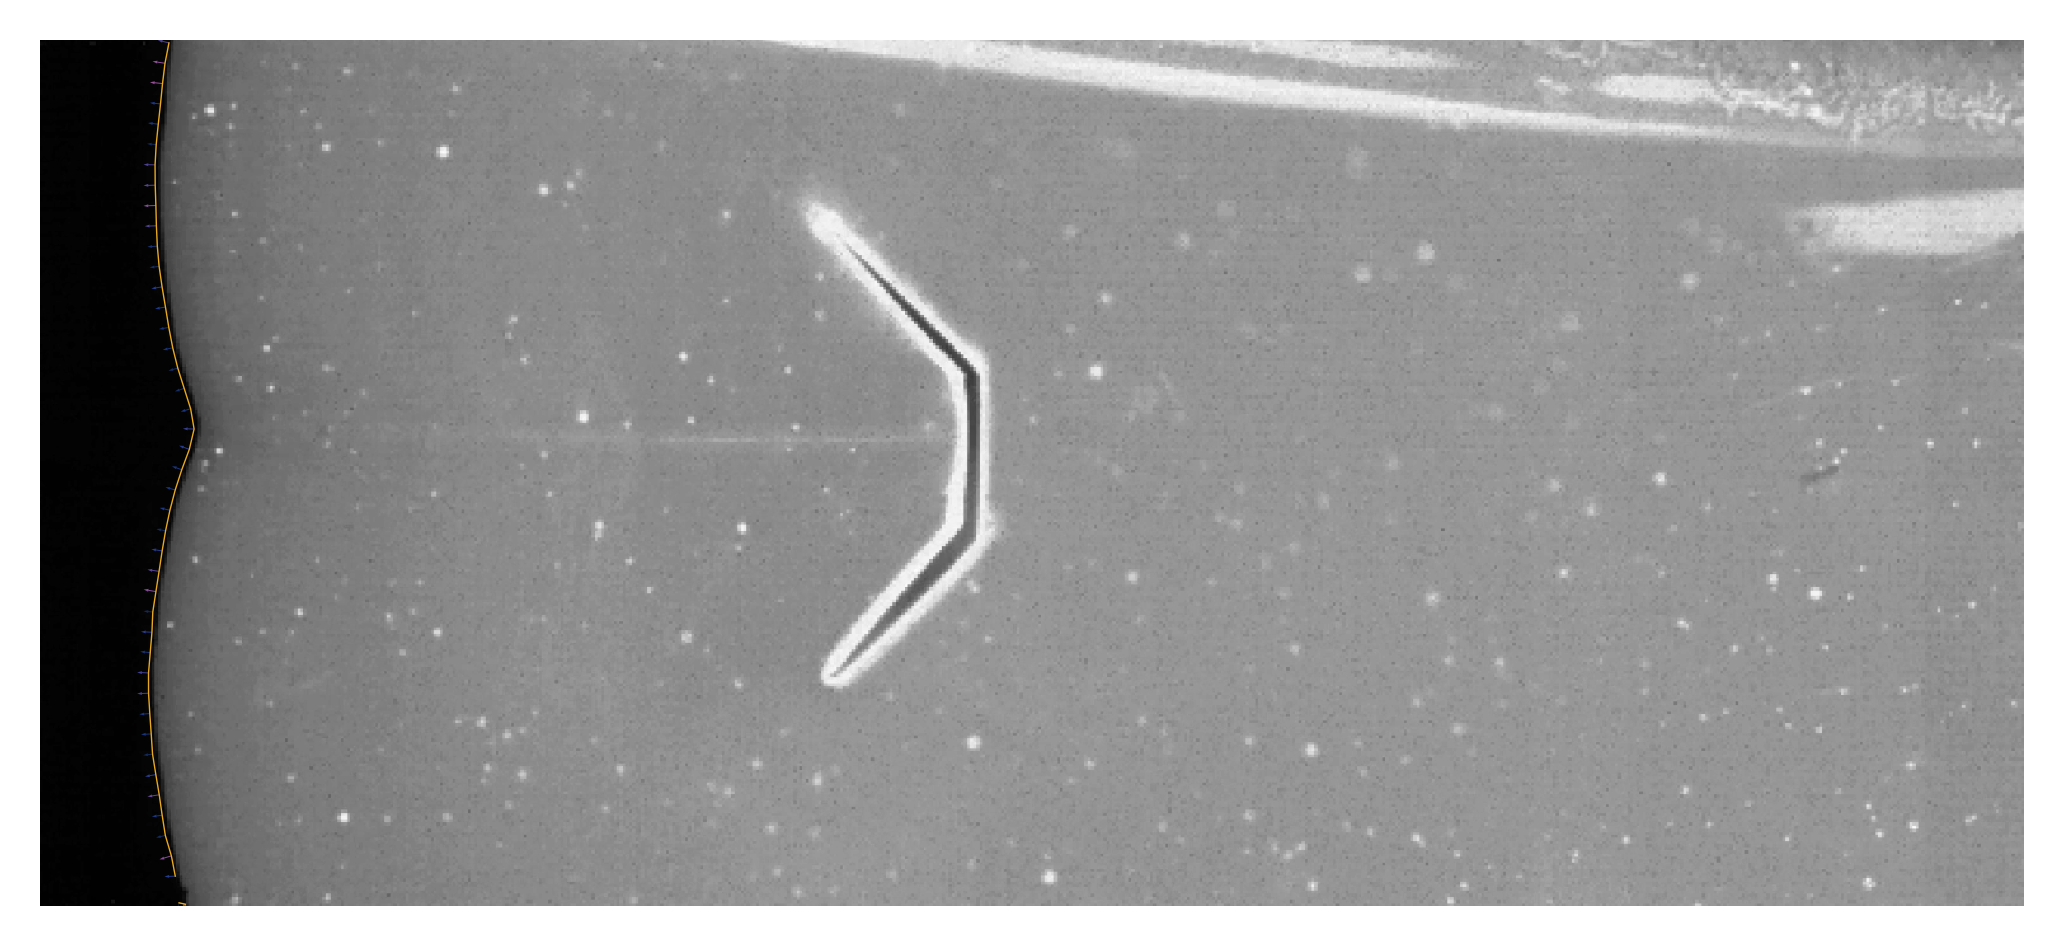

In [2]:
VIDEO_NAMES = os.listdir("videos/")

for video_name in VIDEO_NAMES:
    print(f"Processing {video_name}")
    params = {"video name": video_name, "threshold": 25, "min_length": 5}

    video_title = video_name.split(".")[0]

    experiment_dir = "results/experiment11"
    experiment_name = f"experiment11_{video_title}_debug_outlier_handling2"

    Doc = Documenter(experiment_dir, experiment_name, params, True)
    Doc.comment(
        "I think I just forgot to reload the notebook, that's why performance was worse."
        "I now want to know where the few outliers I still observe come from."
    )

    frames = get_video_frames(f"videos/{params['video name']}")
    # frames are processed inplace by front_from_frames.
    frames_raw = get_video_frames(f"videos/{params['video name']}")

    # Initialize the front
    h, w = frames[0].shape
    for i, _ in tqdm(enumerate(frames[:-2])):

        fig = plt.figure(dpi=400)
        plt.imshow(frames_raw[i], cmap="gray")

        front = front_from_frames(frames[i], frames[i + 1], threshold=params["threshold"])
        front_next = front_from_frames(frames[i + 1], frames[i + 2], threshold=params["threshold"])

        contours = contours_from_front(front, min_length=params["min_length"])
        contours_next = contours_from_front(front_next, min_length=params["min_length"])

        for j, contour in enumerate(contours):

            contour = process_contour(contour)

            if len(contour) < 3:
                continue

            spline, normals = spline_from_contour(contour)

            plt.plot(spline[:, 0], spline[:, 1], linewidth=0.25, color=dfki_cmap(250))

            for point, normal in zip(spline, normals):
                min_dist, _ = dist_to_nearest(point, contours_next)

                if min_dist == np.inf:
                    continue

                plt.quiver(
                    point[0],
                    point[1],
                    normal[0],
                    normal[1],
                    color=dfki_cmap(dist_to_idx(min_dist)),
                    angles="xy",
                    scale_units="xy",
                    scale=1 / (min_dist + 10e-6),
                    width=0.0005,
                )

        plt.axis("off")
        plt.savefig(experiment_dir + "/" + experiment_name + f"/frame_{i}.png")
        plt.close(fig)